# Macro Project (Countries: United Kingdom and Costa Rica)


## Package Imports

In [1]:
import pandas as pd # this is used for dataframes
import numpy as np # this is used for mathematical operations (logs)
import matplotlib.pyplot as plt # for graphs
import scipy.stats as stats # for regression

## Importing the Data

In [2]:
# importing the data from Penn World Tables Excel file
penn_tables = pd.read_excel("data/pwt100.xlsx", sheet_name = "Data") 

In [3]:
# Slicing the data frame to isolate the required variables and countries
variables = ["year", "country", "rgdpna", "emp", "rnna", "hc"]
data = penn_tables.loc[(penn_tables["country"] == "United Kingdom") | (penn_tables["country"] == "Costa Rica")].copy()
data = data[variables]

#removing indexing from the original excel file
data.reset_index(drop=True, inplace=True)

In [4]:
# Extracting our required metrics and creating a log transformed column for each metric
metrics = variables[-4:] 
for i in range(len(metrics)):
    data["log_" + metrics[i]] = data[metrics[i]].apply(lambda x: np.log(x))


## Regression Time Trend of Real GDP

### Linear Regression via `scipy.stats`

In [5]:
# Linear regression of real GDP time series for Costa Rica and UK
cr_res = stats.linregress(data.loc[data["country"] == "Costa Rica", "year"], data.loc[data["country"] == "Costa Rica", "log_rgdpna"])
uk_res = stats.linregress(data.loc[data["country"] == "United Kingdom", "year"], data.loc[data["country"] == "United Kingdom", "log_rgdpna"])

In [6]:
#line of best fit for Costa Rica's fitted trend path
cr_res

LinregressResult(slope=0.04578160444826016, intercept=-80.84230120629528, rvalue=0.9931356679646816, pvalue=4.126570602795587e-65, stderr=0.0006538762219540655, intercept_stderr=1.2976846182123352)

In [7]:
#line of best fit for UK's fitted trend path
uk_res

LinregressResult(slope=0.023899613651845807, intercept=-33.250418517307054, rvalue=0.9967599487595415, pvalue=3.5917080440302806e-76, stderr=0.00023387549124331844, intercept_stderr=0.46414996810302805)

### Plotting the Real GDP Time Trend Path

In [8]:
#globally setting default font size for all plots
plt.rcParams['font.size'] = 26

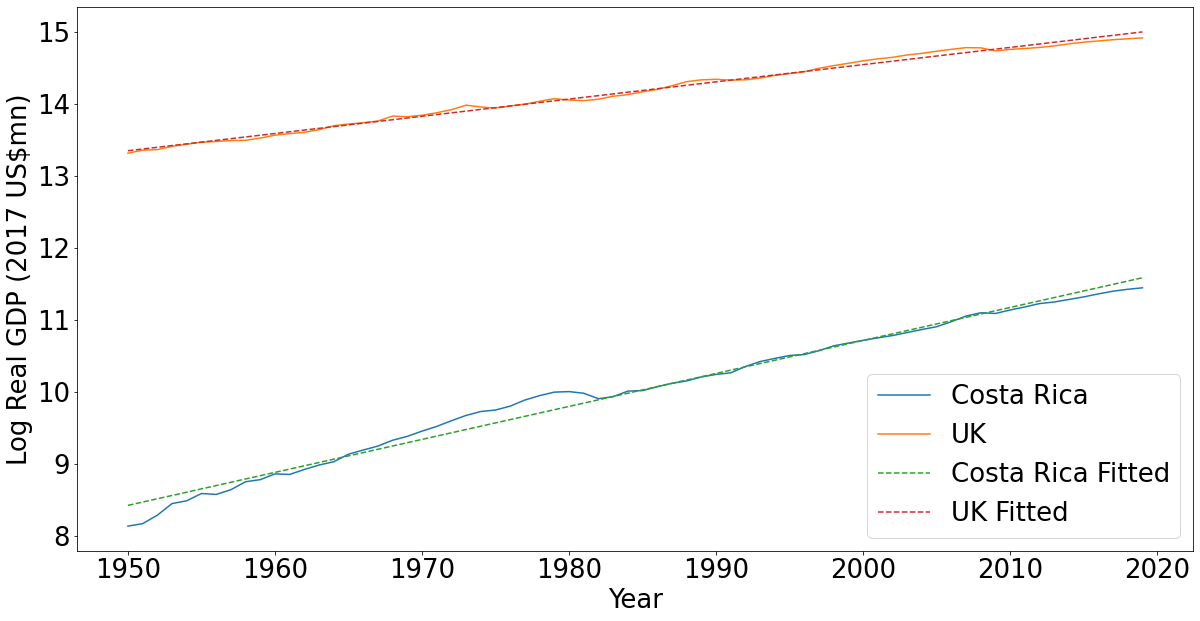

In [9]:
# creating a plot of the GDP time series and the fitted values for linear regression 
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(data.loc[data["country"] == "Costa Rica", "year"], data.loc[data["country"] == "Costa Rica", "log_rgdpna"], label = "Costa Rica") #plot CR Actual log_rgdp
ax.plot(data.loc[data["country"] == "United Kingdom", "year"], data.loc[data["country"] == "United Kingdom", "log_rgdpna"], label = "UK") #plot UK Actual log_rgdp
ax.plot(data.loc[data["country"] == "Costa Rica", "year"], cr_res.intercept + cr_res.slope*data.loc[data["country"] == "Costa Rica", "year"], label = "Costa Rica Fitted", linestyle = 'dashed') #plot fitted CR log_rgdp
ax.plot(data.loc[data["country"] == "United Kingdom", "year"], uk_res.intercept + uk_res.slope*data.loc[data["country"] == "United Kingdom", "year"], label = "UK Fitted", linestyle = 'dashed') #plot fitted UK log_rgdp

# add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Log Real GDP (2017 US$mn)')
plt.show()

## Calculating TFP

### Production function without human capital

In [10]:
# setting the value of alpha in the production function
alpha = 0.3

#calculating tfp and log tfp using the production function equation
data['log_tfp'] = data['log_rgdpna'] - alpha*data['log_rnna']-(1-alpha)*data['log_emp']
data['tfp'] = data["log_tfp"].apply(lambda x: np.exp(x))

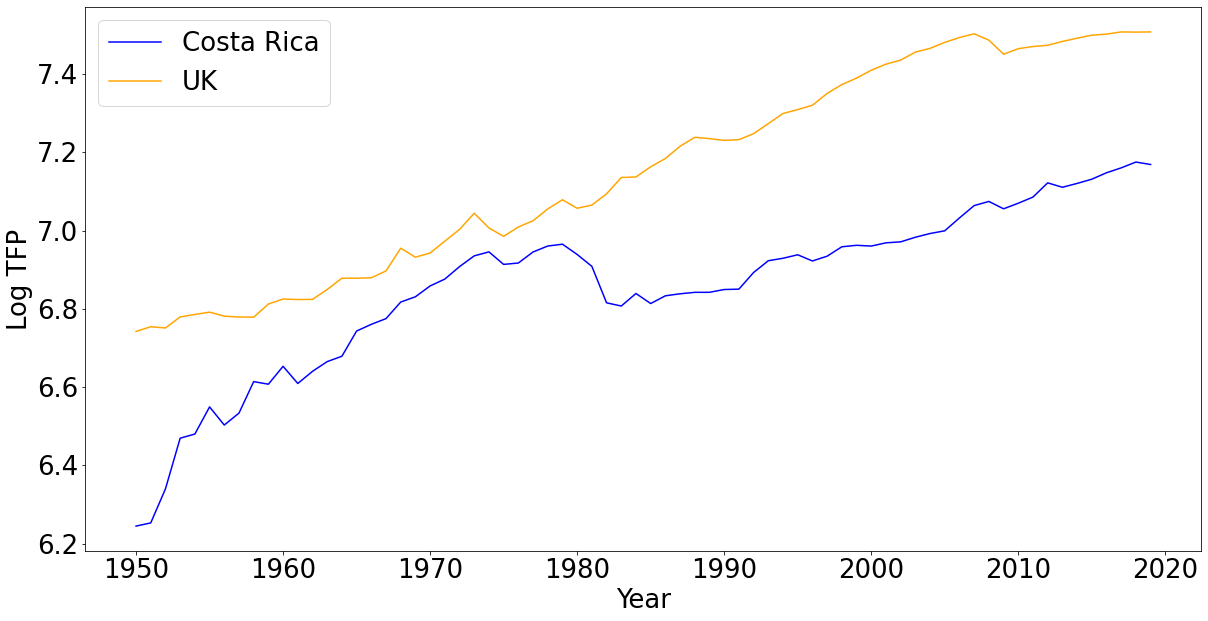

In [11]:
#plotting log tfp
fig, ax = plt.subplots(figsize = (20,10)) # sizing the graph
ax.plot(data.loc[data["country"] == "Costa Rica", "year"], data.loc[data["country"] == "Costa Rica", "log_tfp"], label = "Costa Rica", color = "blue") # plot CR TFP
ax.plot(data.loc[data["country"] == "United Kingdom", "year"], data.loc[data["country"] == "United Kingdom", "log_tfp"], label = "UK", color = "orange") # plot UK TFP

# add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Log TFP')
plt.show()

### Production Function with Human Capital

In [12]:
# calculating log tfp with human capital using the production function equation
data['log_tfp_hc'] = data['log_tfp'] - (1-alpha)*data['log_hc'] 
data['tfp_hc'] = data['log_tfp_hc'].apply(lambda x: np.exp(x)) 

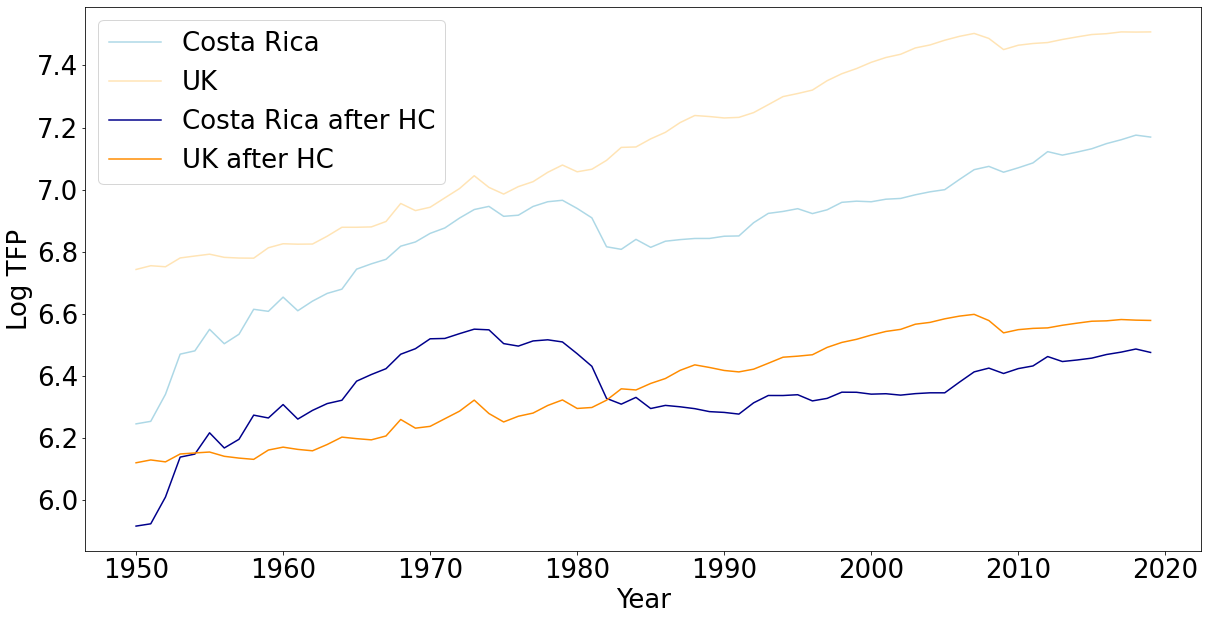

In [13]:
# plotting UK and Costa Rica log TFP with and without human capital
fig, ax = plt.subplots(figsize = (20,10)) 

# plotting log TFP
ax.plot(data.loc[data["country"] == "Costa Rica", "year"], data.loc[data["country"] == "Costa Rica", "log_tfp"], label = "Costa Rica", color = "lightblue") 
ax.plot(data.loc[data["country"] == "United Kingdom", "year"], data.loc[data["country"] == "United Kingdom", "log_tfp"], label = "UK", color = "moccasin") 
# plotting log TFP inclusive of HC
ax.plot(data.loc[data["country"] == "Costa Rica", "year"], data.loc[data["country"] == "Costa Rica", "log_tfp_hc"], label = "Costa Rica after HC", color = "darkblue") 
ax.plot(data.loc[data["country"] == "United Kingdom", "year"], data.loc[data["country"] == "United Kingdom", "log_tfp_hc"], label = "UK after HC", color = "darkorange") 

# add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Log TFP')
plt.show()

## Growth Accounting

In [14]:
# adding tfp_hc as a label to the metrics list
metrics.append("tfp_hc")

In [15]:
# creating metrics list with log to filter log variables
log_metrics = ["log_" +i for i in metrics]

# creating metrics list with d_ to filter yearly log differences
d_metrics = ["d_" + i for i in metrics]

# creating individual dataframes for UK and Costa Rica's variables
costa_rica = data[data["country"] == "Costa Rica"]
del costa_rica["country"]
uk = data[data["country"] == "United Kingdom"]
del uk["country"]

# setting the year as index 
costa_rica.set_index("year", drop = True, inplace = True)
uk.set_index("year", drop = True, inplace = True)

### Uk Growth Accounting

In [16]:
# creating a dataframe to get yearly growth rates in variables for the UK by subtracting log differences
# filtering every 5th year as we are doing growth accounting using 5 year periods
d_uk = uk.iloc[::5]

# adding 2019 as the sample size of our data is not a multiple of 5 resulting in ommision of 2019
d_uk = pd.concat([d_uk, uk.iloc[-1:]], axis = 0)

# filtering log transformed variables 
d_uk = d_uk.loc[:, log_metrics]
d_uk = d_uk.diff()

# renaming columns to indicate log differences
d_uk.columns = d_metrics

#calculating the contribution of each variable to output growth
d_uk["Contribution of Labour"] = (1-alpha)*d_uk["d_emp"]/d_uk["d_rgdpna"]
d_uk["Contribution of Capital"] = alpha*d_uk["d_rnna"]/d_uk["d_rgdpna"]
d_uk["Contribution of Human Capital"] = (1-alpha)*d_uk["d_hc"]/d_uk["d_rgdpna"]
d_uk["Contribution of TFP"] = d_uk["d_tfp_hc"]/d_uk["d_rgdpna"]

# changing d_uk's index to reflect that growth comparison is between 5 years 
years = list(d_uk.index)
ranges = [str(years[x]) + "-" + str(years[x+1]) for x in range(len(years)-1)]
d_uk = d_uk.iloc[1:]
d_uk.index = ranges

d_uk

,d_rgdpna,d_emp,d_rnna,d_hc,d_tfp_hc,Contribution of Labour,Contribution of Capital,Contribution of Human Capital,Contribution of TFP
1950-1955,0.152652,0.043788,0.242519,0.020884,0.034627,0.200793,0.476610,0.095764,0.226833
1955-1960,0.097433,-0.004744,0.223864,0.025521,0.015730,-0.034084,0.689285,0.183354,0.161445
1960-1965,0.154320,0.041353,0.240822,0.036809,0.027359,0.187578,0.468163,0.166969,0.177290
1965-1970,0.122103,-0.018056,0.234104,0.035551,0.039625,-0.103512,0.575182,0.203808,0.324522
1970-1975,0.099951,0.008253,0.172347,0.040410,0.014182,0.057802,0.517295,0.283009,0.141894
1975-1980,0.110432,0.005370,0.116331,0.040410,0.043487,0.034038,0.316024,0.256148,0.393790
1980-1985,0.116270,-0.021672,0.084481,0.036468,0.080569,-0.130477,0.217977,0.219557,0.692943
1985-1990,0.172042,0.086010,0.148361,0.036468,0.041799,0.349956,0.258706,0.148382,0.242957
1990-1995,0.080244,-0.039480,0.097134,0.046617,0.046108,-0.344396,0.363143,0.406660,0.574593
1995-2000,0.176455,0.064511,0.102500,0.046617,0.067915,0.255915,0.174266,0.184932,0.384887


### Costa Rica Growth accounting

In [17]:
# creating a dataframe to get yearly growth rates in variables for Costa Rica by subtracting log differences
# filtering every 5th year as we are doing growth accounting using 5 year periods
d_costa_rica = costa_rica.iloc[::5]

# adding 2019 as the sample size of our data is not a multiple of 5 resulting in ommision of 2019
d_costa_rica = pd.concat([d_costa_rica, costa_rica.iloc[-1:]], axis = 0)

# filtering log transformed variables 
d_costa_rica = d_costa_rica.loc[:, log_metrics]
d_costa_rica = d_costa_rica.diff()

# renaming columns to indicate log differences
d_costa_rica.columns = d_metrics

#calculating the contribution of each variable to output growth
d_costa_rica["Contribution of Labour"] = (1-alpha)*d_costa_rica["d_emp"]/d_costa_rica["d_rgdpna"]
d_costa_rica["Contribution of Capital"] = alpha*d_costa_rica["d_rnna"]/d_costa_rica["d_rgdpna"]
d_costa_rica["Contribution of Human Capital"] = (1-alpha)*d_costa_rica["d_hc"]/d_costa_rica["d_rgdpna"]
d_costa_rica["Contribution of TFP"] = d_costa_rica["d_tfp_hc"]/d_costa_rica["d_rgdpna"]

# changing d_costa_rica's index to reflect that growth comparison is between 5 years 
years = list(d_costa_rica.index)
ranges = [str(years[x]) + "-" + str(years[x+1]) for x in range(len(years)-1)]
d_costa_rica = d_costa_rica.iloc[1:]
d_costa_rica.index = ranges

d_costa_rica

,d_rgdpna,d_emp,d_rnna,d_hc,d_tfp_hc,Contribution of Labour,Contribution of Capital,Contribution of Human Capital,Contribution of TFP
1950-1955,0.452155,0.118567,0.215198,0.005744,0.300578,0.183559,0.142782,0.008892,0.664767
1955-1960,0.272028,0.133388,0.249679,0.018216,0.091001,0.343244,0.275353,0.046874,0.334530
1960-1965,0.273596,0.157903,0.243049,0.021077,0.075396,0.403997,0.266505,0.053925,0.275573
1965-1970,0.320134,0.180186,0.262594,-0.030378,0.136490,0.393991,0.246078,-0.066423,0.426354
1970-1975,0.293184,0.210444,0.302904,0.100676,-0.015471,0.502452,0.309946,0.240372,-0.052770
1975-1980,0.255454,0.181514,0.343320,0.082769,-0.032540,0.497387,0.403188,0.226806,-0.127382
1980-1985,0.014100,0.168808,0.071017,0.073267,-0.176658,8.380558,1.511005,3.637377,-12.528940
1985-1990,0.224185,0.194326,0.174504,0.069050,-0.012529,0.606767,0.233517,0.215603,-0.055887
1990-1995,0.263110,0.154515,0.220640,0.045392,0.056984,0.411084,0.251575,0.120764,0.216577
1995-2000,0.210050,0.165813,0.239016,0.029158,0.001866,0.552577,0.341370,0.097171,0.008882


In [18]:
# calculating average annual growth rates in each variable for the UK
# creating a dataframe for yearly growth rates by subtracting log differences between successive years
avg = uk[log_metrics].diff()

#calculating the contribution of each variable to output growth
avg["Contribution of Labour"] = (1-alpha)*avg["log_emp"]/avg["log_rgdpna"]
avg["Contribution of Capital"] = alpha*avg["log_rnna"]/avg["log_rgdpna"]
avg["Contribution of Human Capital"] = (1-alpha)*avg["log_hc"]/avg["log_rgdpna"]
avg["Contribution of TFP"] = avg["log_tfp_hc"]/avg["log_rgdpna"]

# removing the first row as it is undefined
avg = avg.iloc[1:]

# obtaining summary statistics
uk_sum = avg.describe()
uk_sum

,log_rgdpna,log_emp,log_rnna,log_hc,log_tfp_hc,Contribution of Labour,Contribution of Capital,Contribution of Human Capital,Contribution of TFP
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.023186,0.005094,0.028425,0.006352,0.006646,0.105668,0.303906,0.127032,0.463394
std,0.019993,0.012085,0.013991,0.002238,0.017057,0.833937,0.639076,0.349624,1.073263
min,-0.042010,-0.027520,0.009444,0.002094,-0.043203,-4.211464,-1.827566,-1.345965,-1.382188
25%,0.014203,0.000644,0.018055,0.005104,-0.003652,0.048417,0.176274,0.089516,0.112651
50%,0.024280,0.008850,0.022022,0.007110,0.006761,0.216723,0.249227,0.134413,0.394247
75%,0.034462,0.011687,0.039604,0.008082,0.017780,0.336682,0.382651,0.216494,0.563988
max,0.069200,0.032009,0.064738,0.009324,0.053045,2.435874,3.506090,1.630677,7.128394


In [19]:
# calculating average annual growth rates in each variable for Costa Rica
# creating a dataframe for yearly growth rates by subtracting log differences between successive years
avg2 = costa_rica[log_metrics].diff()

#calculating the contribution of each variable to output growth
avg2["Contribution of Labour"] = (1-alpha)*avg2["log_emp"]/avg2["log_rgdpna"]
avg2["Contribution of Capital"] = alpha*avg2["log_rnna"]/avg2["log_rgdpna"]
avg2["Contribution of Human Capital"] = (1-alpha)*avg2["log_hc"]/avg2["log_rgdpna"]
avg2["Contribution of TFP"] = avg2["log_tfp_hc"]/avg2["log_rgdpna"]

# removing the first row as it is undefined
avg2 = avg2.iloc[1:]

# obtaining summary statistics
cr_sum = avg2.describe()
cr_sum


,log_rgdpna,log_emp,log_rnna,log_hc,log_tfp_hc,Contribution of Labour,Contribution of Capital,Contribution of Human Capital,Contribution of TFP
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.047931,0.030108,0.044879,0.007548,0.008108,0.446726,0.241796,0.139077,0.172400
std,0.034445,0.012179,0.014265,0.007158,0.032922,0.713425,0.477568,0.282149,1.370536
min,-0.075643,-0.004663,-0.001788,-0.006076,-0.103430,-2.986429,-2.039840,-0.448813,-5.052759
25%,0.033809,0.024531,0.038193,0.003643,-0.006010,0.331634,0.200096,0.023122,-0.040118
50%,0.045545,0.030730,0.045563,0.006878,0.007369,0.419038,0.274548,0.129635,0.203538
75%,0.067301,0.035462,0.053278,0.013810,0.021342,0.513837,0.349822,0.202365,0.411852
max,0.160929,0.062832,0.076624,0.023393,0.128695,3.569906,2.187102,1.546963,6.431156


### Graphing the contribution of each variable to output growth

In [20]:
# create a dataframe with uk_mean and cr_mean
means = uk_sum.iloc[1, -4:]*uk_sum.loc["mean", "log_rgdpna"]
cr_mean = cr_sum.iloc[1, -4:]*cr_sum.loc["mean", "log_rgdpna"]
means = means.to_frame()
cr_mean = cr_mean.to_frame()
means.columns = ["UK"]
cr_mean.columns = ["Costa Rica"]
means["Costa Rica"] = cr_mean["Costa Rica"]
means

,UK,Costa Rica
Contribution of Labour,0.002450,0.021412
Contribution of Capital,0.007046,0.011590
Contribution of Human Capital,0.002945,0.006666
Contribution of TFP,0.010744,0.008263


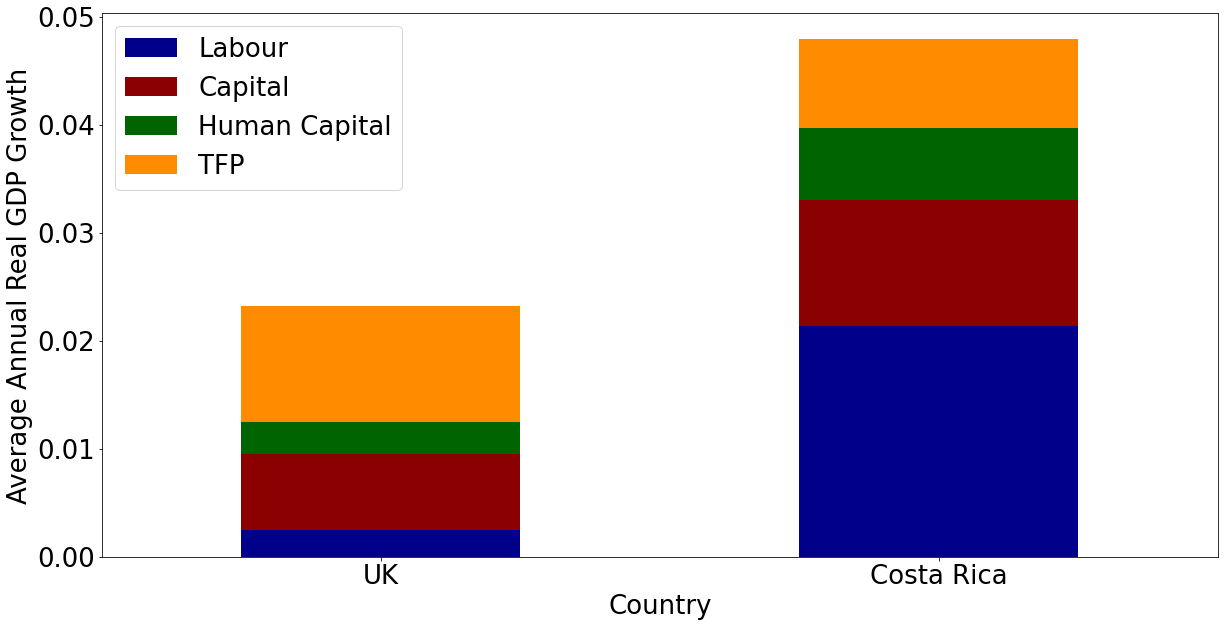

In [21]:
#creating the bar plot by transposing the means dataframe
fig, ax = plt.subplots(figsize = (20,10))
means = means.T
means.plot(kind = "bar", ax = ax, stacked=True, color = ["darkblue", "darkred", "darkgreen", "darkorange"])

# X legend is horizontal
plt.xticks(rotation=0)

# set labels
ax.set_xlabel("Country")
ax.set_ylabel("Average Annual Real GDP Growth")

# legend of variables without the word "Contribution of"
ax.legend([i[16:] for i in means.columns])

plt.show()

## Miscellaneous Calculations

In [56]:
# UK TFP Growth 1950-1970

avg.iloc[:20, 4].mean()

0.0058670626729102615

In [62]:
# UK Capital Growth 1950-1980

avg.iloc[:30, 2].mean()

0.040999590943151115

## Graphs from World Bank

### Corruption Control

In [22]:
# importing data on corruption from the world bank
corruption = pd.read_csv("data/Corruption Control_Data.csv")

In [23]:
# transposing the dataframe
corruption = corruption.T

corruption.columns = corruption.iloc[0]

# drop rows that are not years
corruption = corruption.drop(corruption.index[0:4])

# set column name to year
corruption.columns.name = None

In [24]:
# isolate the year from the index
corruption.index = [t[0] for t in corruption.index.str.split(" ", n = 1, expand = True)]

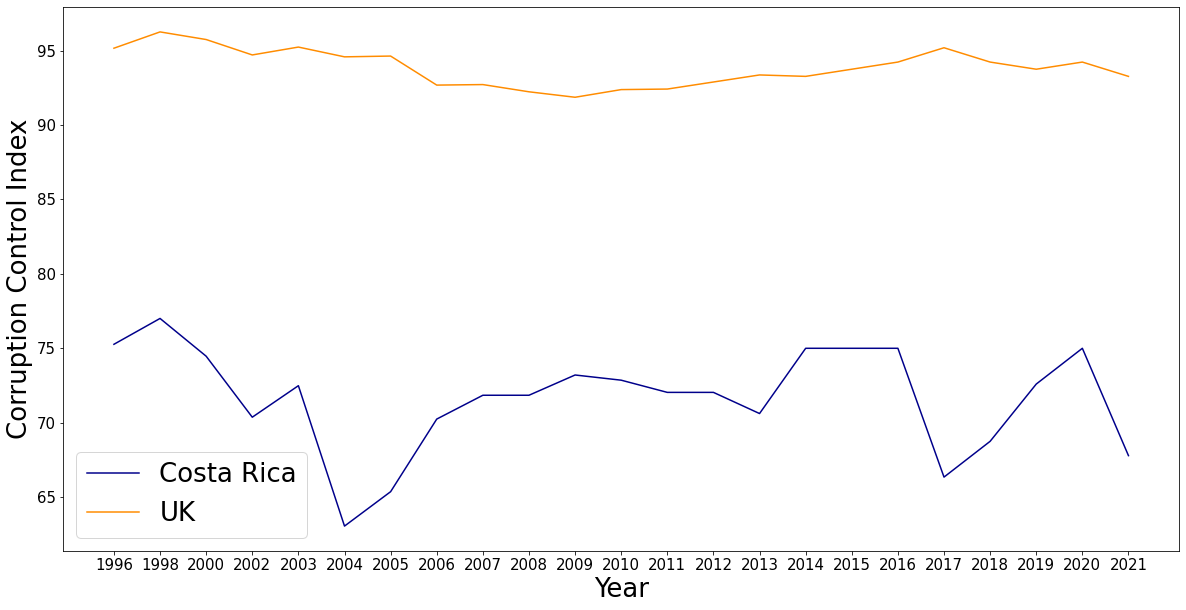

In [25]:
# plotting the corruption index data 
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(corruption.index, corruption["Costa Rica"], label = "Costa Rica", color = "darkblue") 
ax.plot(corruption.index, corruption["United Kingdom"], label = "UK", color = "darkorange") 

# adding legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Corruption Control Index')
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

### R&D Expenditure

In [26]:
# reading r&d data
rd = pd.read_csv("data/R&D Expenditure.csv")

In [27]:
#transposing the dataframe
rd = rd.T

In [28]:
rd.columns = rd.iloc[0]

# drop rows that are not years
rd = rd.drop(rd.index[0:4])

In [29]:
# remove the first 3 columns
rd = rd.iloc[:, 3:]

#resting index to country names
rd.set_index("Country Name", inplace = True)
rd.index.name = None

In [30]:
# choose only the columns of Costa Rica and the United Kingdom
rd = rd.loc[1996:, ["Costa Rica", "United Kingdom"]]

In [31]:
# fill in the missing values with the average of the previous and next value
# convert to numeric so that we can interpolate
rd["Costa Rica"] = pd.to_numeric(rd["Costa Rica"], errors = "coerce")
rd["United Kingdom"] = pd.to_numeric(rd["United Kingdom"], errors = "coerce")

# interpolate
rd = rd.interpolate()

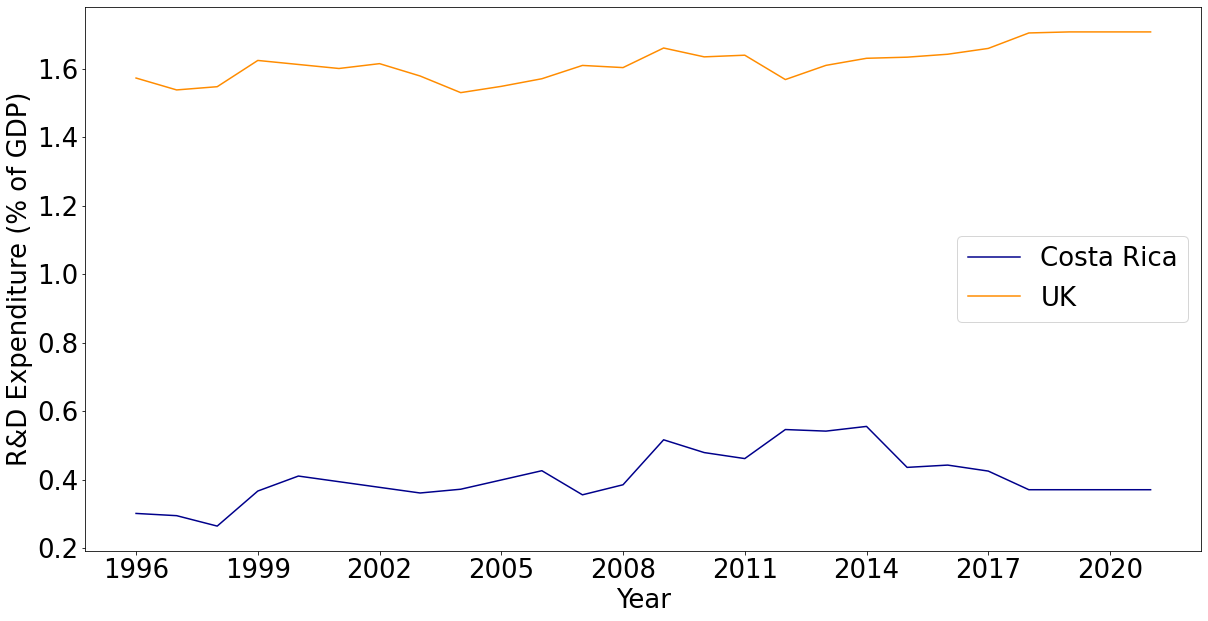

In [32]:
#creating the line plot
fig, ax = plt.subplots(figsize = (20,10)) # sizing the graph
ax.plot(rd.index, rd["Costa Rica"], label = "Costa Rica", color = "darkblue")  # plot CR R&D
ax.plot(rd.index, rd["United Kingdom"], label = "UK", color = "darkorange") # plot UK R&D

# add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('R&D Expenditure (% of GDP)')
ax.set_xticks(range(1996, 2021, 3))
plt.show()

### UK Private Credit

In [33]:
# reading the data into a dataframe
credit = pd.read_csv("data/UK Credit.csv")

In [34]:
# transposing the dataframe
credit = credit.T

credit.columns = credit.iloc[0]

# drop rows that are not years
credit = credit.drop(credit.index[0:4])

In [35]:
# locating data only for the UK
credit = credit.loc[:,["Country Name", "United Kingdom"]]

# setting index and column names
credit.set_index("Country Name", inplace = True)
credit.index.name = None
credit.columns.name = None

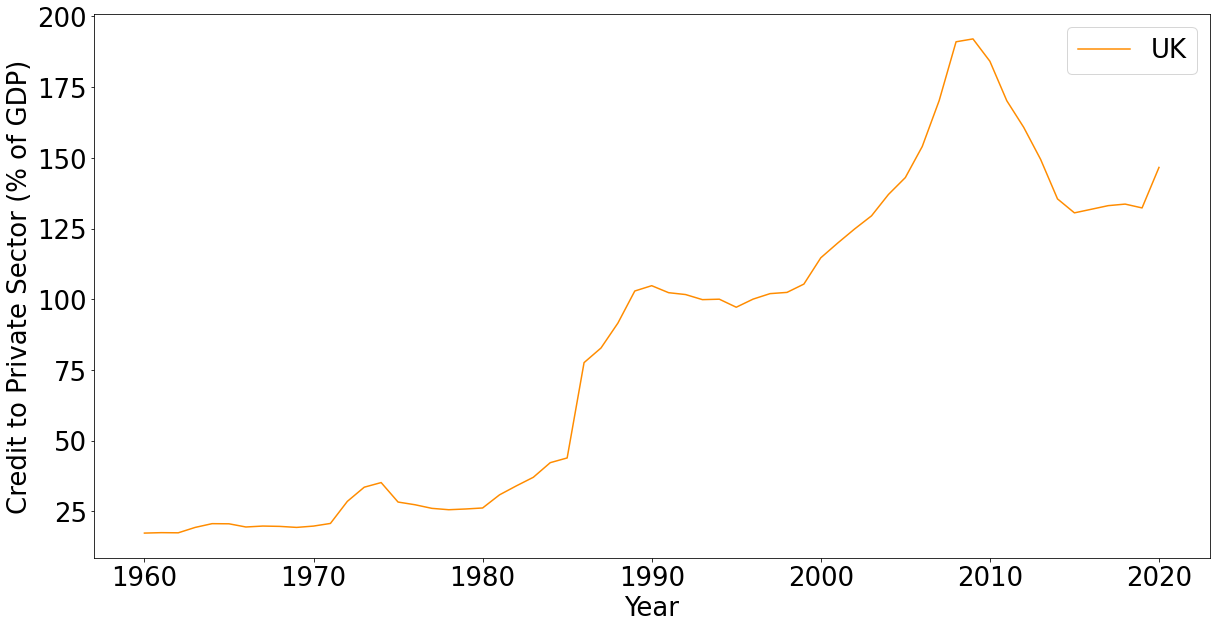

In [36]:
fig, ax = plt.subplots(figsize = (20,10)) # sizing the graph
ax.plot(credit.index, credit["United Kingdom"], label = "UK", color = "darkorange") # plot UK Credit

# add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Credit to Private Sector (% of GDP)')
plt.show()

### UK Women Labour Participation

In [49]:
# reading data on women labour participation
women = pd.read_csv("data/UK_women_labour_participation.csv")

# only extracting yearly data as opposed to quartlerly
women = women.iloc[7:59]
women.rename(columns = {"Title": "Year"}, inplace = True)
women["Year"]=women["Year"].astype(int)

#changing datatype to flat for plotting
women["Female employment rate (aged 16 to 64, seasonally adjusted): %"] = women["Female employment rate (aged 16 to 64, seasonally adjusted): %"].astype(str).astype(float)

#changing index to year
women.set_index("Year", inplace = True, drop = True)

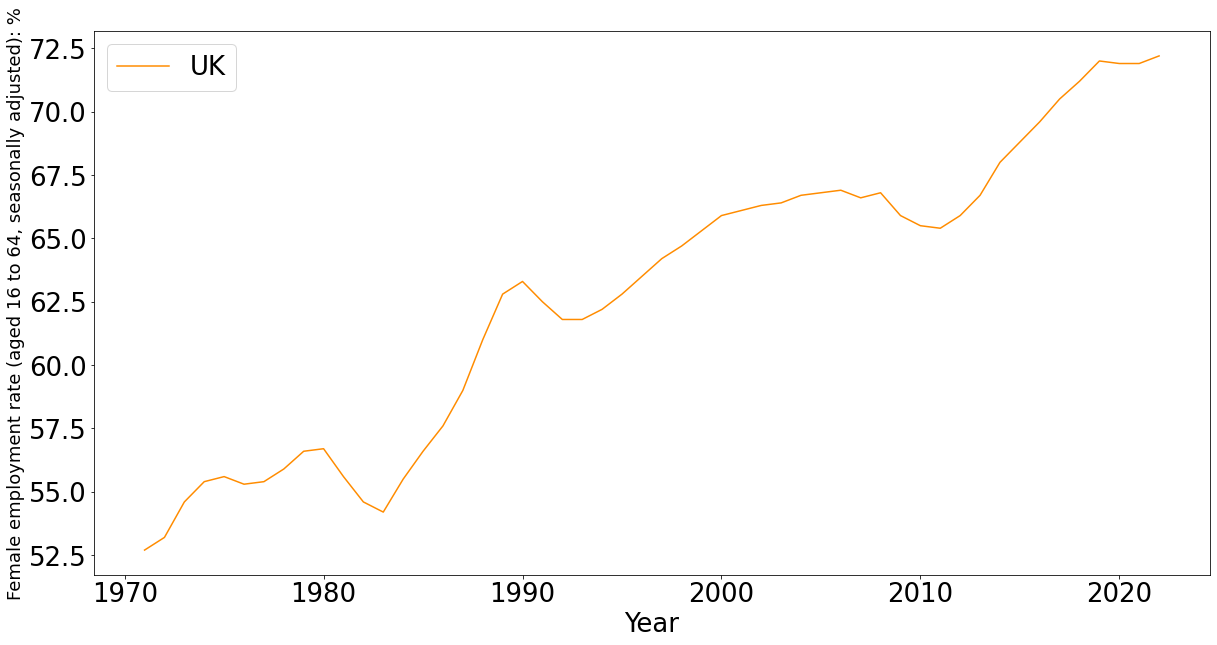

In [51]:
# plotting the graph
fig, ax = plt.subplots(figsize = (20,10)) # sizing the graph
ax.plot(women.index, women["Female employment rate (aged 16 to 64, seasonally adjusted): %"], label = "UK", color = "darkorange") 

# add legend and labels
ax.legend()
ax.set_xlabel('Year')

ax.set_ylabel('Female employment rate (aged 16 to 64, seasonally adjusted): %' , fontsize = 18)
plt.show()

### UK Stock Market Capitalisation

In [39]:
# reading the data into a dataframe
stocks = pd.read_csv("data/UK Stocks.csv")

In [40]:
# transposing the dataframe
stocks = stocks.T
stocks.columns = stocks.iloc[0]

# drop rows that are not years
stocks = stocks.drop(stocks.index[0:4])

In [41]:
# locating data only for the UK
stocks = stocks.loc[:,["Country Name", "United Kingdom"]]

# setting index and column names
stocks.set_index("Country Name", inplace = True)
stocks.index.name = None
stocks.columns.name = None

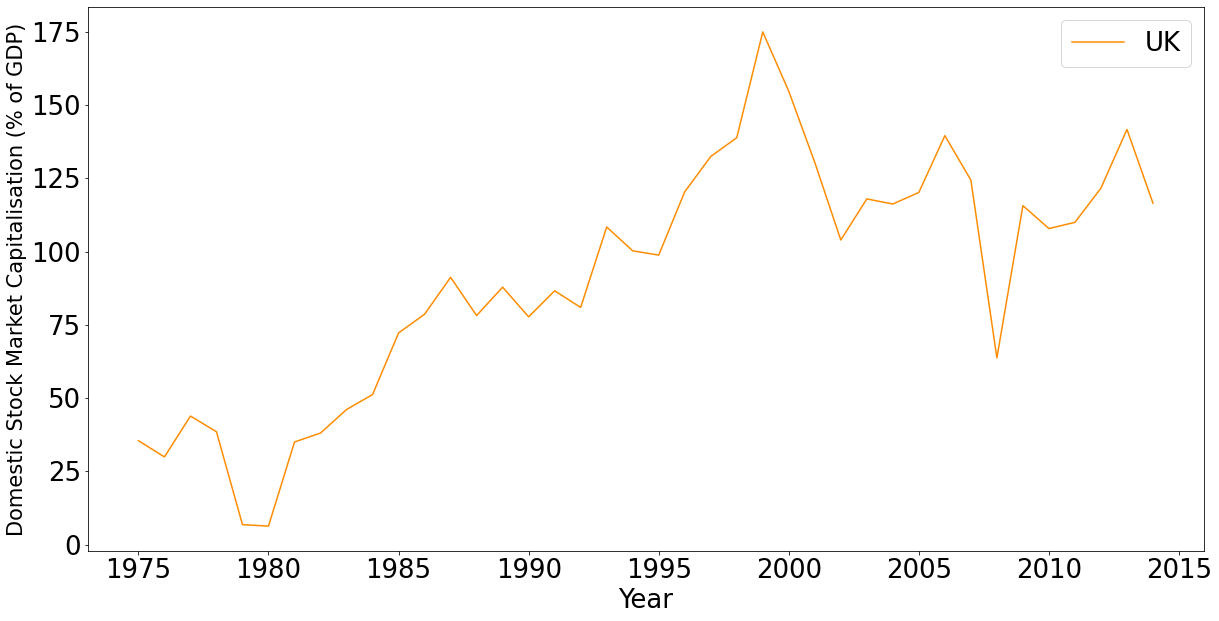

In [42]:
fig, ax = plt.subplots(figsize = (20,10)) # sizing the graph
ax.plot(stocks.index, stocks["United Kingdom"], label = "UK", color = "darkorange") # plot UK Stocks

# add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Domestic Stock Market Capitalisation (% of GDP)', fontsize = 21)
plt.show()

### Exploring the Latin American Debt Crisis

We can graph the TFP of each country to see whether there has been a material change for all affected countries.

In [43]:
# list of countries affected by the debt crisis that we are interested in
latam_countries = ['Costa Rica', 'Venezuela', 'Brazil', 'Argentina', 'Mexico', 'Chile'] 

In [44]:
# create a new dataframe with the variables we are interested in
debt_crisis_check = penn_tables[variables].copy() 

# filter the dataframe to only include the latam countries
debt_crisis_check = debt_crisis_check[debt_crisis_check["country"].isin(latam_countries)] 



In [45]:
# apply the log function to each of the variables and calculating TFP and TFP with HC for LATAM countries

for i in range(len(metrics)-1):
    debt_crisis_check["log_" + metrics[i]] = debt_crisis_check[metrics[i]].apply(lambda x: np.log(x))
    
debt_crisis_check['log_tfp'] = debt_crisis_check['log_rgdpna'] - alpha*debt_crisis_check['log_rnna']-(1-alpha)*debt_crisis_check['log_emp']
debt_crisis_check['log_tfp_hc'] = debt_crisis_check['log_tfp'] - (1-alpha)*debt_crisis_check['log_hc']


#### Plot each country's TFP over time

In [46]:
# define a different colour for each country graph
def colour(country):
    if country == "Costa Rica":
        return "darkblue"
    if country == "Venezuela":
        return "grey"
    elif country == "Brazil":
        return "lightgrey"
    elif country == "Argentina":
        return "darkgrey"
    elif country == "Mexico":
        return "silver"
    elif country == "Chile":
        return "gainsboro"

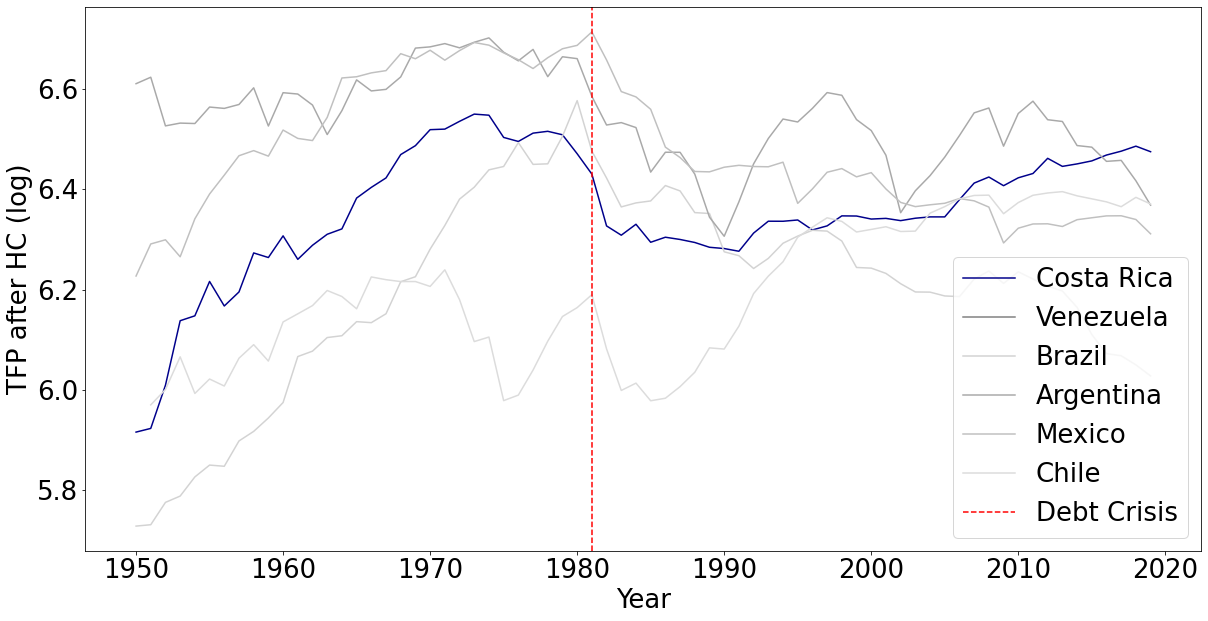

In [47]:
#plotting TFP including HC for each of of the LATAM countries
fig, ax = plt.subplots(figsize = (20,10))
for country in latam_countries:

    ax.plot(debt_crisis_check.loc[debt_crisis_check["country"] == country, "year"], debt_crisis_check.loc[debt_crisis_check["country"] == country, "log_tfp_hc"], label = country, color = colour(country))

# draw a vertical line at the year before the debt crisis
ax.axvline(x = 1981, color = "red", linestyle = "--", label = "Debt Crisis")

# add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('TFP after HC (log)')
plt.show()